A 0
A 100
A 200
A 300
A 400
A 500
A 600
A 700
A 800
A 900
B 0
B 100
B 200
B 300
B 400
B 500
B 600
B 700
B 800
B 900


2024-03-08 22:19:53.675754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-08 22:19:53.678988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-08 22:19:53.679139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-08 22:19:53.679359: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
gradlayer (MaxPooling2D)     (None, 16, 16, 64)        0     

2024-03-08 22:19:55.663243: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2024-03-08 22:19:56.274972: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100


  1/100 [..............................] - ETA: 2:29 - loss: 0.7112 - accuracy: 0.3750

2024-03-08 22:19:57.046764: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 [==============================] - 2s 5ms/step - loss: 0.1697 - accuracy: 0.9237 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 2/10
100/100 [==============================] - 0s 4ms/step - loss: 3.1545e-04 - accuracy: 1.0000 - val_loss: 3.3464e-05 - val_accuracy: 1.0000
Epoch 3/10
100/100 [==============================] - 0s 4ms/step - loss: 3.8438e-05 - accuracy: 1.0000 - val_loss: 1.6492e-05 - val_accuracy: 1.0000
Epoch 4/10
100/100 [==============================] - 0s 4ms/step - loss: 2.6517e-05 - accuracy: 1.0000 - val_loss: 5.7231e-06 - val_accuracy: 1.0000
Epoch 5/10
100/100 [==============================] - 0s 4ms/step - loss: 1.6337e-05 - accuracy: 1.0000 - val_loss: 1.3253e-06 - val_accuracy: 1.0000
Epoch 6/10
100/100 [==============================] - 0s 4ms/step - loss: 4.2246e-06 - accuracy: 1.0000 - val_loss: 8.5183e-07 - val_accuracy: 1.0000
Epoch 7/10
100/100 [==============================] - 0s 4ms/step - loss: 2.9981e-06 - accuracy: 1.0000 - val_loss: 3.2

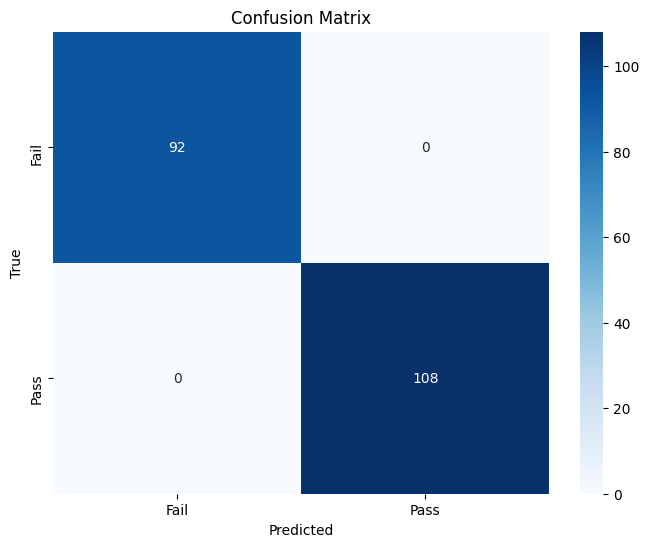

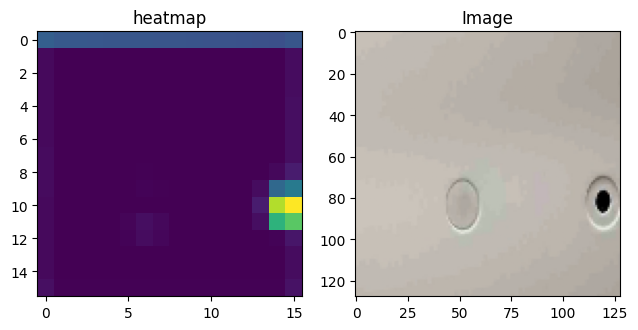

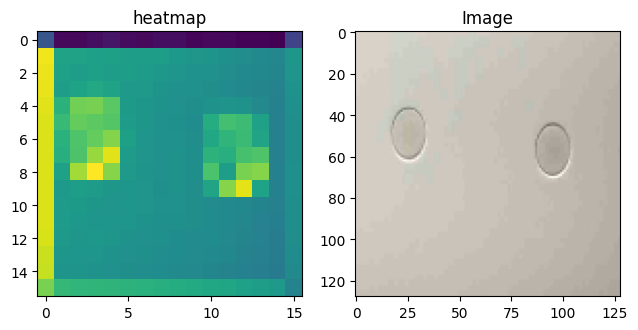

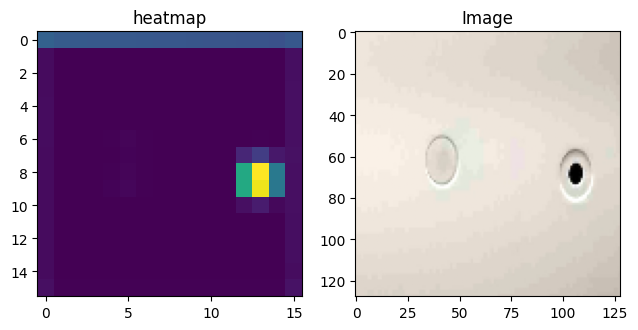

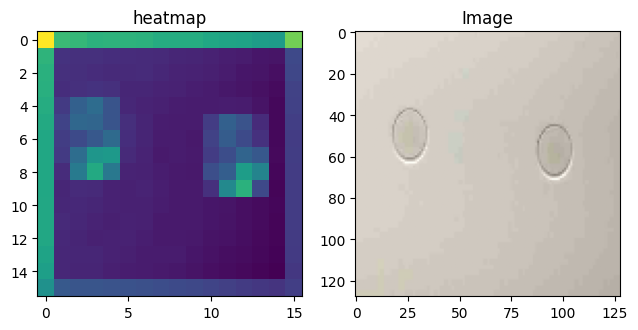

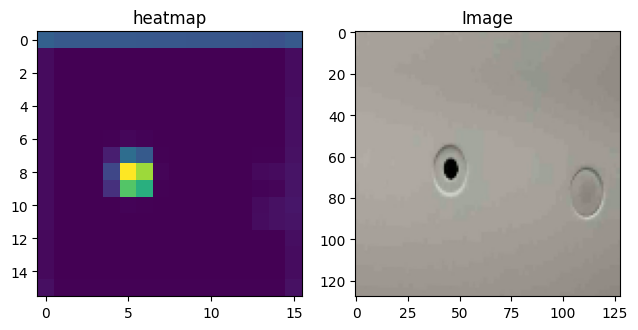

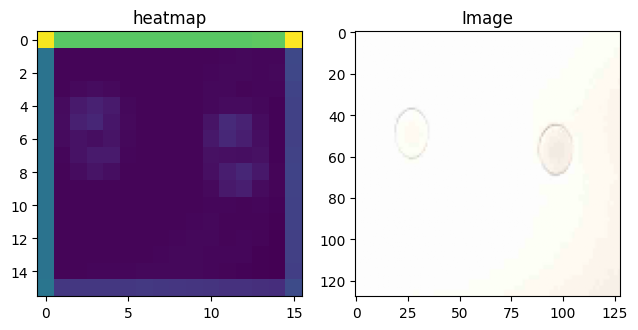

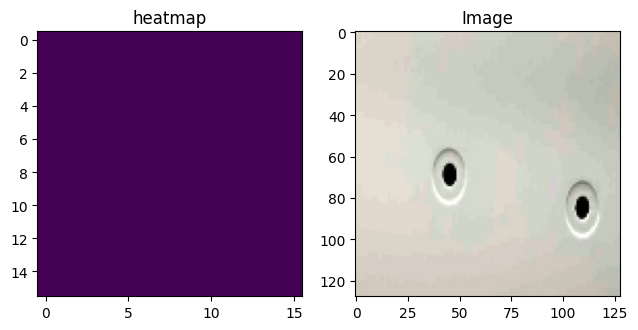

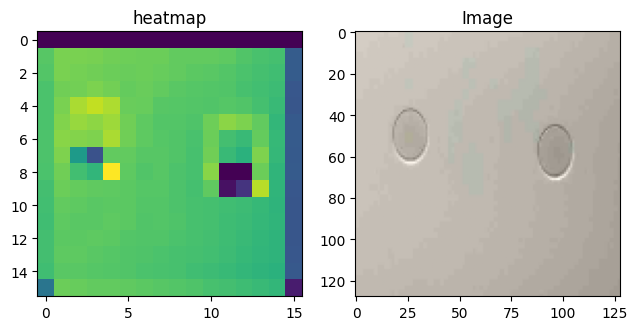

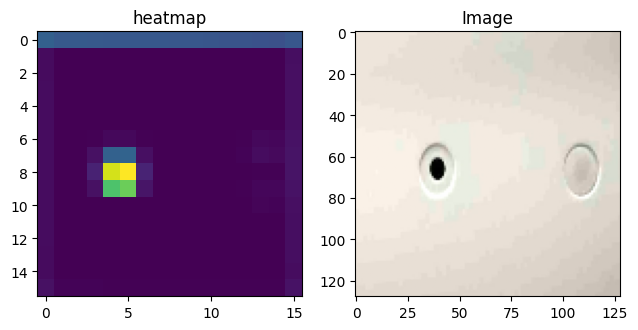

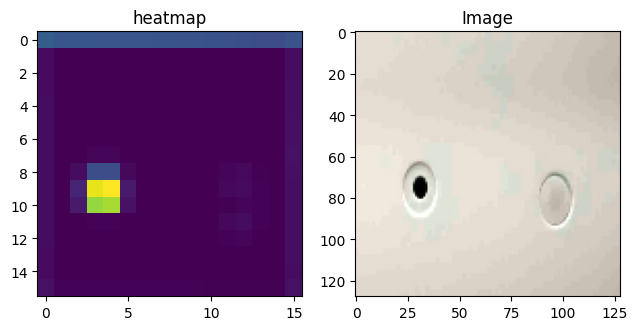

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
import copy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.metrics import Recall
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

directory = '../../HS1'

def functional_model(height, width, outdim):
    # Define the input layer
    inputs = Input(shape=(height, width, 3))

    # 첫번째 conv+pooling layer
    x = Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # 두번째 conv+pooling layer
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # 세번째 conv+pooling layer
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name = 'gradlayer')(x)

    
    x = Flatten()(x)

    # Dense layer with 512 units
    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    # Output layer with softmax activation
    outputs = Dense(outdim, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

def data_encoder(directory):
    check = os.listdir(directory)
    fail_dir = os.path.join(directory, check[0])
    pass_dir = os.path.join(directory, check[1])
    fail_imgs = []
    pass_imgs = []
    n = 0
    for img in os.listdir(fail_dir):
        img_path = os.path.join(fail_dir, img)
        image = cv2.imread(img_path)
        crop = image[200:600, 350:950, :]
        fail_imgs.append(crop)
        if n % 100 == 0:
            print("A", n)
        n += 1
    n = 0
    for img in os.listdir(pass_dir):
        img_path = os.path.join(pass_dir, img)
        image = cv2.imread(img_path)
        crop = image[200:600, 350:950, :]
        pass_imgs.append(crop)
        if n % 100 == 0:
            print("B", n)
        n += 1
        if n >= 1000:
            break
    fail_np = np.array(fail_imgs)
    pass_np = np.array(pass_imgs)
    x = np.vstack([fail_np, pass_np])
    y = np.vstack([np.array([[1, 0]] * len(fail_imgs)), np.array([[0, 1]] * len(pass_imgs))])
    return x, y

x, y = data_encoder(directory)
width, height = 128, 128
model = functional_model(width, height, 2)
x = tf.image.resize(x, (width, height))
x = np.array(x) / 255
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
epoch = 10
batch_size = 16

history = model.fit(x_train, y_train, epochs=epoch,
                    validation_data=(x_valid, y_valid),
                    batch_size=batch_size, shuffle=True)#.history

def confusion():
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

confusion()

def gradcam(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis] 
    heatmap = tf.squeeze(heatmap)  # 축 쥐어짜서 (squeeze) 없애주기 ([높이, 너비, 1] -> [높이, 너비]가 됨)
    max_val = tf.math.reduce_max(heatmap)
    if max_val == 0:
        max_val = 1e-10  # 매우 작은 값을 사용하여 나누기 오류 방지
    heatmap = tf.maximum(heatmap, 0) / max_val
    return heatmap

def heatmap(k):
    map = gradcam(x_test[k:k+1], model, 'gradlayer')

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.imshow(map)
    ax1.set_title('heatmap')

    ax2.imshow(x_test[k])
    ax2.set_title('Image')

    plt.tight_layout()
    plt.show()

for i in range(10):
    heatmap(i)

# def loss_plot(self):
#     plt.plot(self.History['loss'])
#     plt.plot(self.History['val_loss'])
#     plt.title('Model Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epochs')
#     plt.legend(['train', 'vaild'])
#     plt.yscale('log')
#     plt.show()




